In [1]:
import os
import io
import zipfile
from pathlib import Path
from datetime import timedelta


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

from tqdm import tqdm
# Time series / forecasting imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [2]:
EXCEL_PATH = 'online_retail_ii.xlsx' # put the Excel file in the same folder or change this path
DOWNLOAD_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online%20retail%20ii.xlsx'
OUTPUT_CSV = 'online_retail_cleaned.csv'

In [3]:


def load_excel(path=EXCEL_PATH, download_url=None):
    if os.path.exists(path):
        print(f"Loading local Excel file: {path}")
        xls = pd.read_excel(path, sheet_name=None)
        return xls
    elif download_url:
        try:
            print(f"Attempting to download from: {download_url}")
            import requests
            r = requests.get(download_url)
            r.raise_for_status()
            # read Excel file from bytes
            xls = pd.read_excel(io.BytesIO(r.content), sheet_name=None)
            return xls
        except Exception as e:
            raise RuntimeError(f"Failed to download or read Excel file: {e}")
    else:
        raise FileNotFoundError(f"Excel file not found at {path}. Set EXCEL_PATH or provide DOWNLOAD_URL.")


In [4]:
# Load data
sheets = load_excel(EXCEL_PATH, download_url=DOWNLOAD_URL)
print('Sheets found:', list(sheets.keys()))

Loading local Excel file: online_retail_ii.xlsx
Sheets found: ['Year 2009-2010', 'Year 2010-2011']


In [5]:
# Concatenate all sheets into one DataFrame
df_list = []
for name, df in sheets.items():
    df['__source_sheet'] = name
    df_list.append(df)


df = pd.concat(df_list, ignore_index=True)
print('\nInitial shape after concatenation:', df.shape)


Initial shape after concatenation: (1067371, 9)


In [6]:
print('\nColumns and dtypes:')
print(df.dtypes)


print('\nSample rows:')
print(df.head(5))


Columns and dtypes:
Invoice                   object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
Price                    float64
Customer ID              float64
Country                   object
__source_sheet            object
dtype: object

Sample rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  __source_sheet  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  Year 2009-2010  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  Year 2009-2010  
2 200

In [7]:
# Cleaning steps
# 1. Trim whitespace in string columns (Description, Country)
# 2. Parse InvoiceDate to datetime (dayfirst=True because the dataset uses day/month/year)
# 3. Remove cancellations: Invoice beginning with 'C' and negative quantities
# 4. Remove rows with missing Customer ID (required for churn modeling)
# 5. Remove rows with Quantity <= 0 or Price <= 0
# 6. Drop exact duplicates
# 7. Create Revenue column
# 8. Standardize dtypes

# 1) Trim strings
str_cols = ['Description', 'Country']
for c in str_cols:
    if c in df.columns:
        df[c] = df[c].astype('string').str.strip()

# 2) Parse dates (idempotent)
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')
    missing_dates = df['InvoiceDate'].isna().sum()
    print(f"Parsed InvoiceDate; missing/invalid dates: {missing_dates}")

# 3) Mark cancellations using Invoice starting with 'C'
if 'Invoice' in df.columns:
    df['Invoice_str'] = df['Invoice'].astype(str)
    df['is_cancelled_by_invoice'] = df['Invoice_str'].str.startswith('C')
else:
    raise KeyError("Column 'Invoice' not found in dataframe")

# Capture counts before cleaning
initial_count = len(df)

# 4) Determine customer column (already existed earlier, but keep safe check)
if 'Customer ID' in df.columns:
    customer_col = 'Customer ID'
elif 'CustomerID' in df.columns:
    customer_col = 'CustomerID'
else:
    raise KeyError('CustomerID column not found; check Excel sheet columns')

missing_cust_before = df[customer_col].isna().sum()
print(f"Missing CustomerID before cleaning: {missing_cust_before}")

# 5) Numeric validity
price_col = 'Price'
required_cols = ['Quantity', price_col]
for col_name in required_cols:
    if col_name not in df.columns:
        raise KeyError(f"Required column '{col_name}' not in dataframe")

mask_positive_qty = df['Quantity'] > 0
mask_positive_price = df[price_col] > 0
mask_no_cancel_invoice = ~df['is_cancelled_by_invoice']
mask_has_customer = ~df[customer_col].isna()

final_mask = mask_positive_qty & mask_positive_price & mask_no_cancel_invoice & mask_has_customer
cleaned_df = df[final_mask].copy()

removed_count = initial_count - len(cleaned_df)
print(f"Rows removed during cleaning: {removed_count} (from {initial_count} to {len(cleaned_df)})")

# 6) Drop exact duplicates (same invoice, stockcode, description, quantity, date, price, customer)
cols_for_dup = ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', price_col, customer_col]
cols_for_dup = [c for c in cols_for_dup if c in cleaned_df.columns]
cleaned_df_before_dup = len(cleaned_df)
cleaned_df = cleaned_df.drop_duplicates(subset=cols_for_dup)
print(f"Dropped {cleaned_df_before_dup - len(cleaned_df)} exact duplicate rows.")

# 7) Create Revenue column
cleaned_df['Revenue'] = cleaned_df['Quantity'] * cleaned_df[price_col]

# 8) Standardize types
cleaned_df[customer_col] = cleaned_df[customer_col].astype(int)

# Reset index
cleaned_df = cleaned_df.reset_index(drop=True)

# Quick summary after cleaning
print('\nCleaned DataFrame shape:', cleaned_df.shape)
print('Number of unique customers:', cleaned_df[customer_col].nunique())
print('Total revenue (cleaned):', cleaned_df['Revenue'].sum())

Parsed InvoiceDate; missing/invalid dates: 0
Missing CustomerID before cleaning: 243007
Rows removed during cleaning: 261822 (from 1067371 to 805549)
Dropped 26124 exact duplicate rows.

Cleaned DataFrame shape: (779425, 12)
Number of unique customers: 5878
Total revenue (cleaned): 17374804.268000003


In [8]:
# Top 10 products by revenue (cleaned)
if 'Description' in cleaned_df.columns:
    top_products = (cleaned_df.groupby('Description')['Revenue']
                    .sum().sort_values(ascending=False).head(10))
    print('\nTop 10 products by revenue:')
    print(top_products)

# %%
# Save cleaned CSV
cleaned_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved cleaned dataset to {OUTPUT_CSV}")


Top 10 products by revenue:
Description
REGENCY CAKESTAND 3 TIER              277656.25
WHITE HANGING HEART T-LIGHT HOLDER    247048.01
PAPER CRAFT , LITTLE BIRDIE           168469.60
Manual                                151777.67
JUMBO BAG RED RETROSPOT               134307.44
POSTAGE                               124648.04
ASSORTED COLOUR BIRD ORNAMENT         124351.86
PARTY BUNTING                         103283.38
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
PAPER CHAIN KIT 50'S CHRISTMAS         76598.18
Name: Revenue, dtype: float64
Saved cleaned dataset to online_retail_cleaned.csv


In [9]:
# Load cleaned dataset (ensure Step 1 was run first)
cleaned_df = pd.read_csv('online_retail_cleaned.csv')


# Ensure InvoiceDate is datetime
cleaned_df['InvoiceDate'] = pd.to_datetime(cleaned_df['InvoiceDate'], errors='coerce')

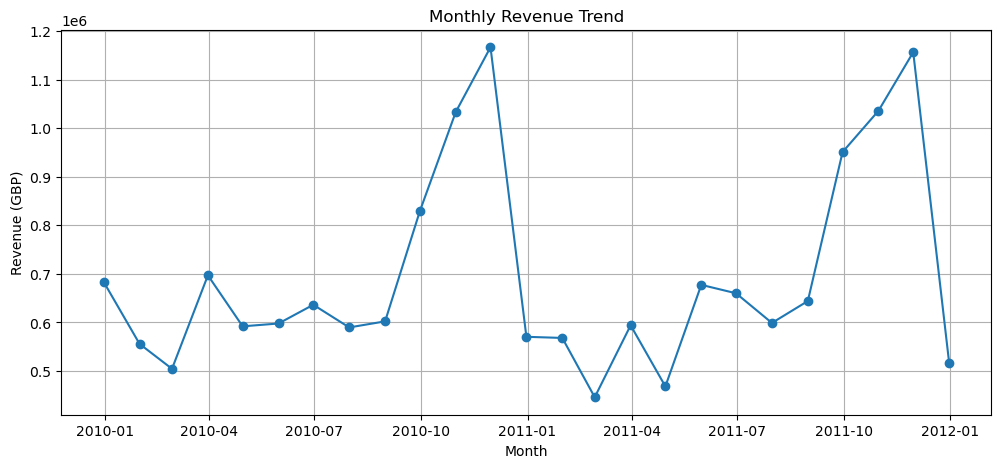

In [10]:
# Visualization 1: Revenue over time (monthly trend)
monthly_revenue = (cleaned_df.set_index('InvoiceDate').resample('M')['Revenue'].sum())

# Convert to plain Python lists to satisfy strict type checkers (avoids ExtensionArray typing issues)
x_vals = list(monthly_revenue.index)          # DatetimeIndex -> list
y_vals = list(monthly_revenue.astype(float))  # Series -> list[float]

plt.figure(figsize=(12,5))
plt.plot(x_vals, y_vals, marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (GBP)')
plt.grid(True)
plt.show()

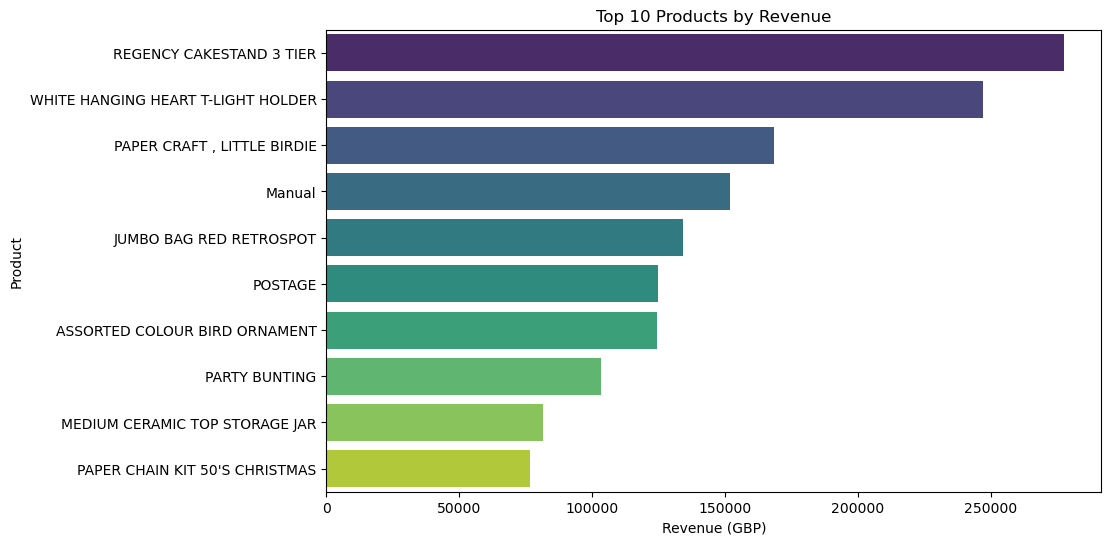

In [11]:
# Visualization 2: Top 10 products by total revenue
product_revenue = (cleaned_df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10))


plt.figure(figsize=(10,6))
sns.barplot(x=product_revenue.values, y=product_revenue.index, hue=product_revenue.index, palette="viridis", legend=False)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue (GBP)')
plt.ylabel('Product')
plt.show()

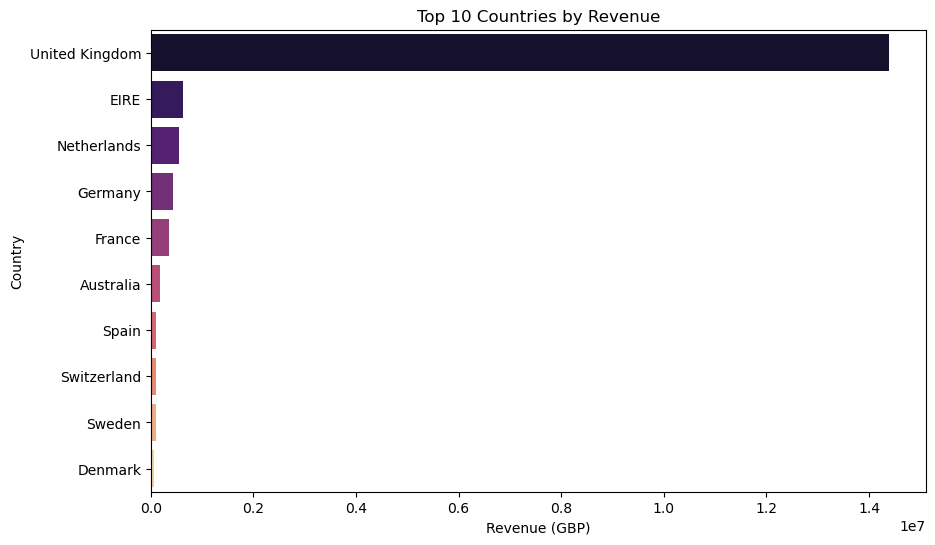

In [12]:
# Visualization 3: Revenue distribution by country (top 10 countries)
country_revenue = (cleaned_df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10))


plt.figure(figsize=(10,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, hue=country_revenue.index, palette="magma", legend=False)
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue (GBP)')
plt.ylabel('Country')
plt.show()

In [13]:
# Step 3 — Customer Churn Prediction
# This step prepares features and trains a classifier to predict whether a customer will
# make another purchase within 90 days after a chosen cutoff date.

# Load cleaned data
cleaned_df = pd.read_csv('online_retail_cleaned.csv')
cleaned_df['InvoiceDate'] = pd.to_datetime(cleaned_df['InvoiceDate'], errors='coerce')

# Use full dataset to pick a cutoff: latest date minus 90 days (so we can label forward 90 days)
max_date = cleaned_df['InvoiceDate'].max()
cutoff = max_date - pd.Timedelta(days=90)
label_window_end = cutoff + pd.Timedelta(days=90)
print(f"Dataset max date: {max_date}, cutoff: {cutoff}, label window end: {label_window_end}")

# Feature window: use transactions up to cutoff. Label: any transaction in (cutoff, cutoff+90d]
train_df = cleaned_df[cleaned_df['InvoiceDate'] <= cutoff].copy()
label_df = cleaned_df[(cleaned_df['InvoiceDate'] > cutoff) & (cleaned_df['InvoiceDate'] <= label_window_end)].copy()

# Aggregate label: for each customer, 1 if they have any purchase in label_df, else 0
invoice_col = 'Invoice'  # original dataset uses 'Invoice', not 'InvoiceNo'
if invoice_col not in label_df.columns:
	raise KeyError(f"Expected invoice column '{invoice_col}' not found in label_df")
label_series = (label_df.groupby('Customer ID')[invoice_col]
				.nunique()
				.rename('future_purchases'))
label_series = (label_series > 0).astype(int)

# Prepare features from train_df: RFM features over last 365 days before cutoff
feature_window_start = cutoff - pd.Timedelta(days=365)
# Restrict to last 365 days lookback
fw_df = train_df[train_df['InvoiceDate'] >= feature_window_start].copy()

# Aggregations per customer
agg = fw_df.groupby('Customer ID').agg(
	frequency=(invoice_col, 'nunique'),
	monetary=('Revenue', 'sum'),
	last_purchase=('InvoiceDate', 'max'),
	distinct_products=('StockCode', 'nunique')
).reset_index()

# Recency: days from last_purchase to cutoff
agg['recency_days'] = (cutoff - agg['last_purchase']).dt.days

# Fill NaNs / type adjustments
agg['monetary'] = agg['monetary'].fillna(0)
agg['frequency'] = agg['frequency'].fillna(0).astype(int)
agg['distinct_products'] = agg['distinct_products'].fillna(0).astype(int)

# Merge with labels (customers with no future purchases will be 0)
data = agg.merge(label_series.rename('will_return_90d'),
				 how='left',
				 left_on='Customer ID',
				 right_index=True)
data['will_return_90d'] = data['will_return_90d'].fillna(0).astype(int)

print('Feature dataset shape:', data.shape)
print('Positive label fraction:', data['will_return_90d'].mean())

# Select features and target
feature_cols = ['recency_days', 'frequency', 'monetary', 'distinct_products']
X = data[feature_cols]
y = data['will_return_90d']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.25, random_state=42, stratify=y
)

# Model
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, y_train)
model = clf  # optional alias

# Predictions & evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}  F1: {f1:.4f}  ROC AUC: {roc:.4f}")

Dataset max date: 2011-12-09 12:50:00, cutoff: 2011-09-10 12:50:00, label window end: 2011-12-09 12:50:00
Feature dataset shape: (4313, 7)
Positive label fraction: 0.5070716438673777
Accuracy: 0.6756  F1: 0.6704  ROC AUC: 0.7386
